# ВВП Ганы

In [139]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme('notebook')
# sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 8)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Загрузка данный и первичный анализ

In [105]:
df = pd.read_csv('data/ghana_gdp.zip', parse_dates=['year'], index_col='year')
df.columns = ['GDP']
df.index.freq = 'YS'
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Freq: AS-JAN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


In [106]:
df

,GDP
year,
1960-01-01,1217086834.73
1961-01-01,0.00
1962-01-01,1382352941.18
1963-01-01,1540616246.50
1964-01-01,1731092436.97
...,...
2017-01-01,60406382898.52
2018-01-01,67299280679.56
2019-01-01,68337537815.77


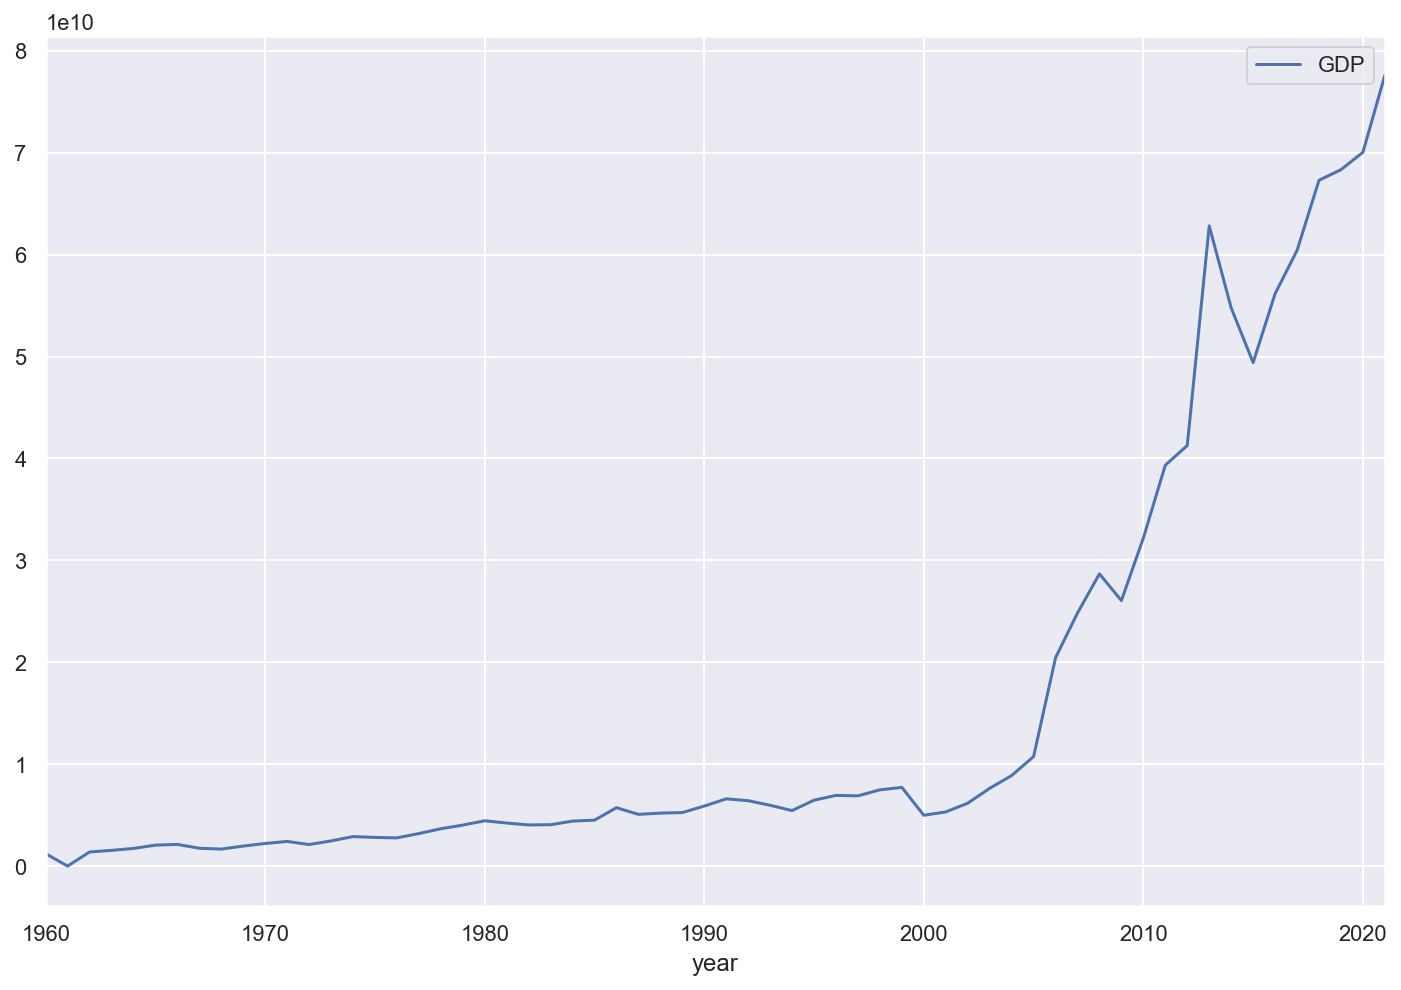

In [107]:
df.plot();

На графике виден экспоненциальный рост

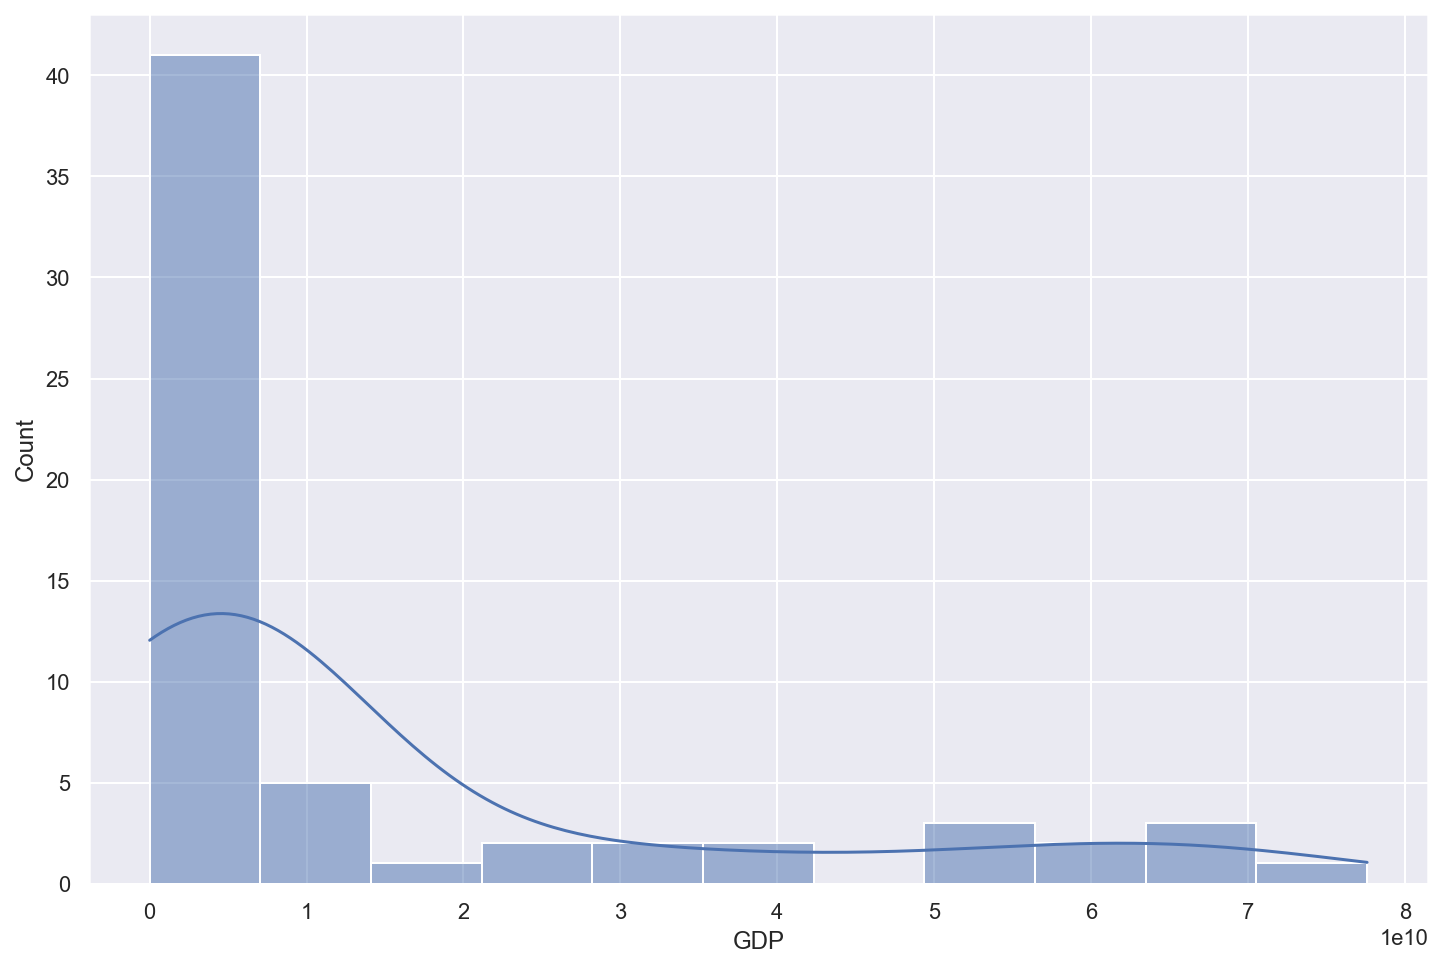

In [108]:
sns.histplot(df['GDP'], kde=True);

Распределение похоже на лог-нормальное

# Разделение выборки

In [109]:
test_period = 3 # последние три года оставляю для теста
train_df, test_df = df.iloc[:-test_period].copy(), df.iloc[-test_period:].copy()

### Произвожу декомпозицию

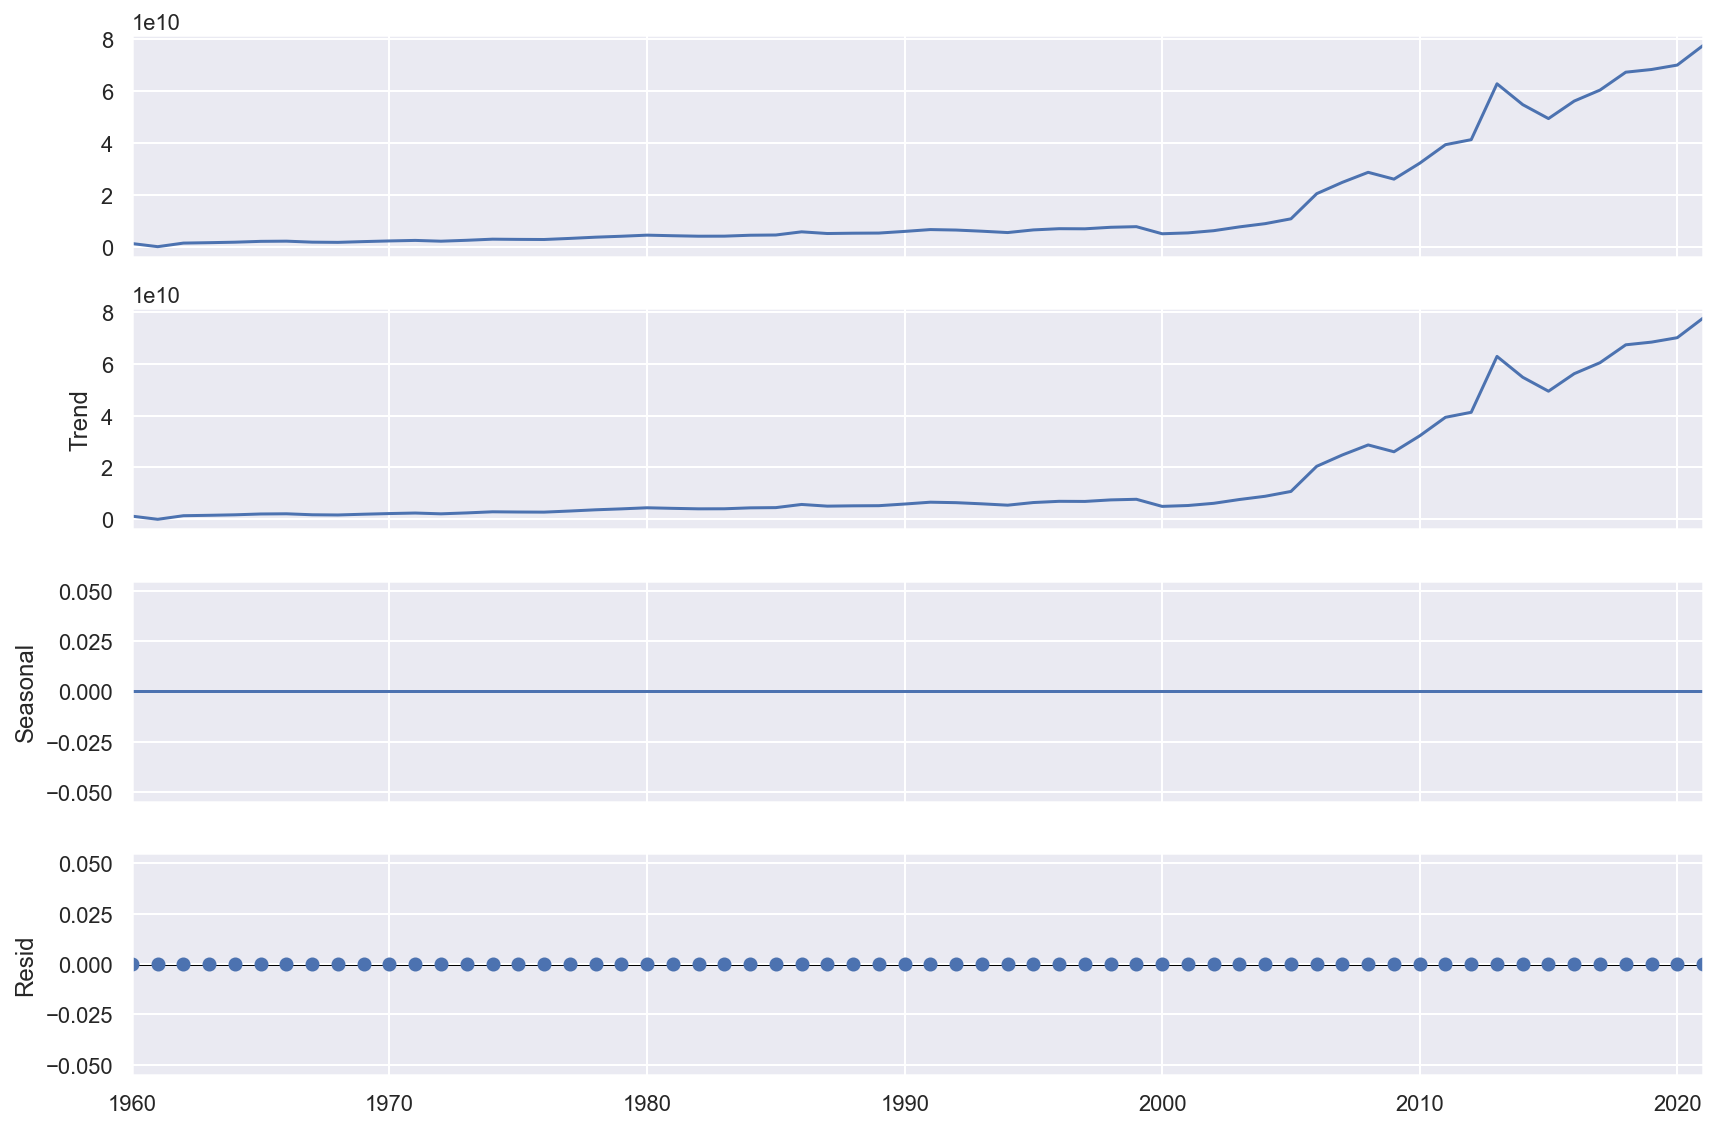

In [110]:
decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show()

- Трендовая компонента не сильно отличается от исходного ряда, тренд есть
- Сезонная компонента отсутствует
- Шум нулевой, что странно

### Визуализация MA
Строю 3х летний краткосрочный цикл и 10ти летний долгосрочный

In [111]:
df_for_plot = df.copy()
df_for_plot['ma_3'] = df_for_plot['GDP'].rolling(3).mean()
df_for_plot['ma_10'] = df_for_plot['GDP'].rolling(10).mean()

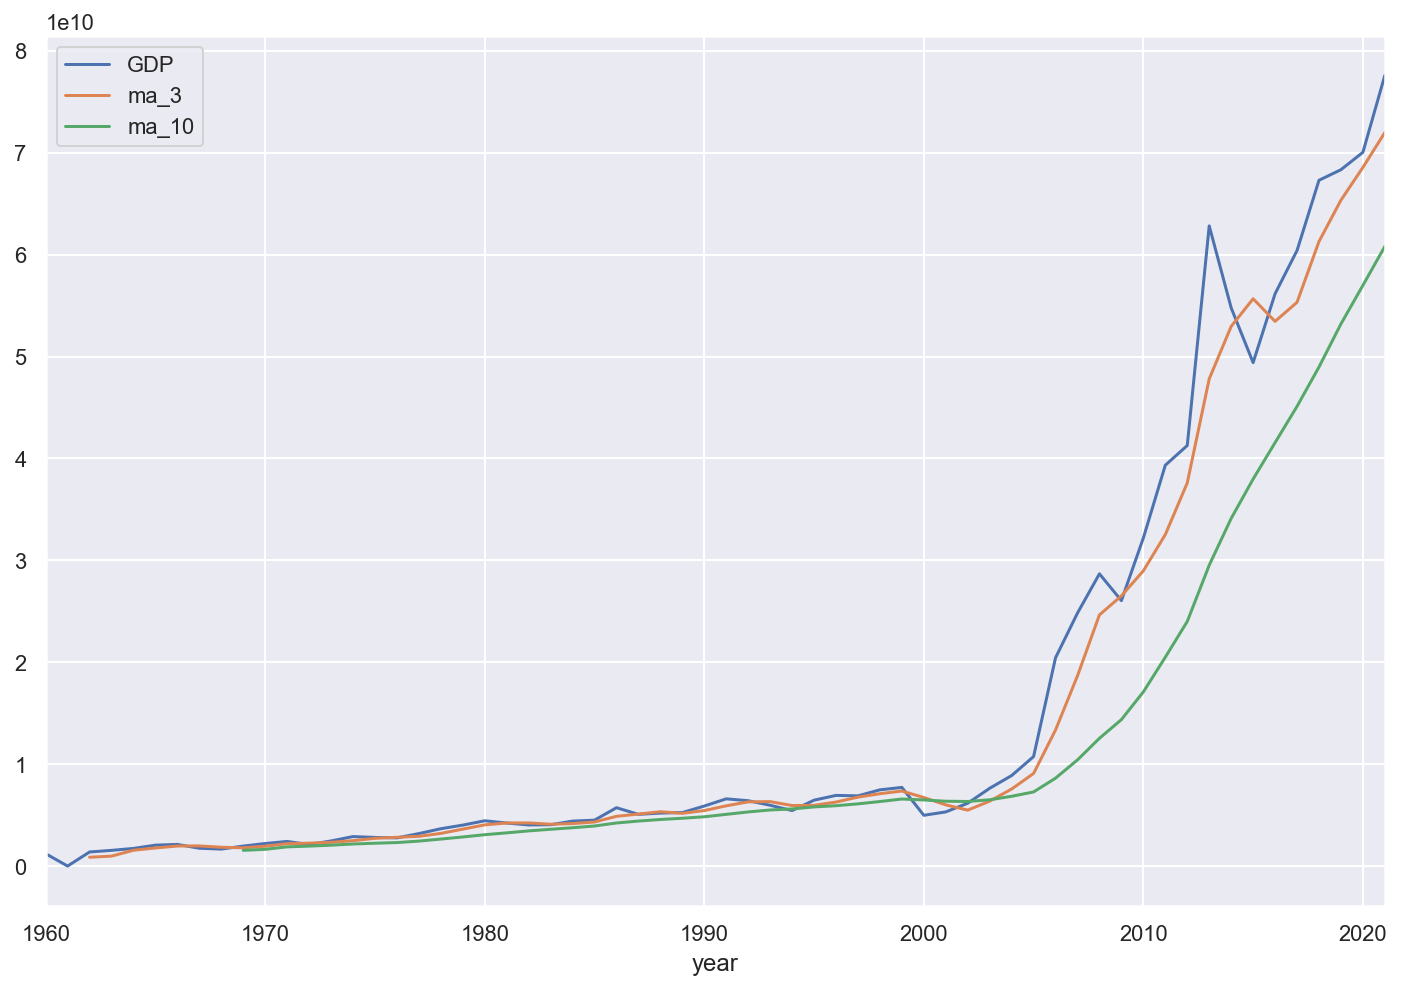

In [112]:
df_for_plot.plot();

# Проверка стационарности

In [113]:
def adf(x, threshold=0.05):
    '''
    Тест стационарности Augmented Dickey-Fuller Test(ADF Test)

    Args:
        x: Вектор значений переданный для проверки на стационарность
        threshold: Уровень достоверности, по умолчанию 5%

    Returns:
    '''

    _, pvalue = adfuller(x)[0], adfuller(x)[1]

    print('Test-Statistic:', _)
    print('P-Value:', pvalue)

    # The null hypothesis of the ADF test is that the time series is non-stationary.
    H0 = 'Time series is non-stationary'
    Ha = 'Time series is stationary!'

    if pvalue <= threshold: # Reject the null hypothesis
        print(Ha)
    else:
        print(H0)

### Проверка на стационарность

In [114]:
adf(df['GDP'])

Test-Statistic: 2.373839356148917
P-Value: 0.9989974617734
Time series is non-stationary


Ряд не стационарен, дифференцирую

In [115]:
gdp_diff = df['GDP'].diff().dropna()
adf(gdp_diff)

Test-Statistic: -1.587944111800476
P-Value: 0.4896467177743541
Time series is non-stationary


Дифференцирую второй раз

In [116]:
gdp_diff = gdp_diff.diff().dropna()
adf(gdp_diff)

Test-Statistic: -1.745908762849135
P-Value: 0.40762748326075393
Time series is non-stationary


Дифференцирую третий раз, ряд по прежнему нестационарен

In [117]:
gdp_diff = gdp_diff.diff().dropna()
adf(gdp_diff)

Test-Statistic: -5.278476343687468
P-Value: 6.066691711555073e-06
Time series is stationary!


Ряд стал стационарным после третьего дифференцирования, значение d = 3

In [118]:
d = 3

### Изучаю коррелограммы

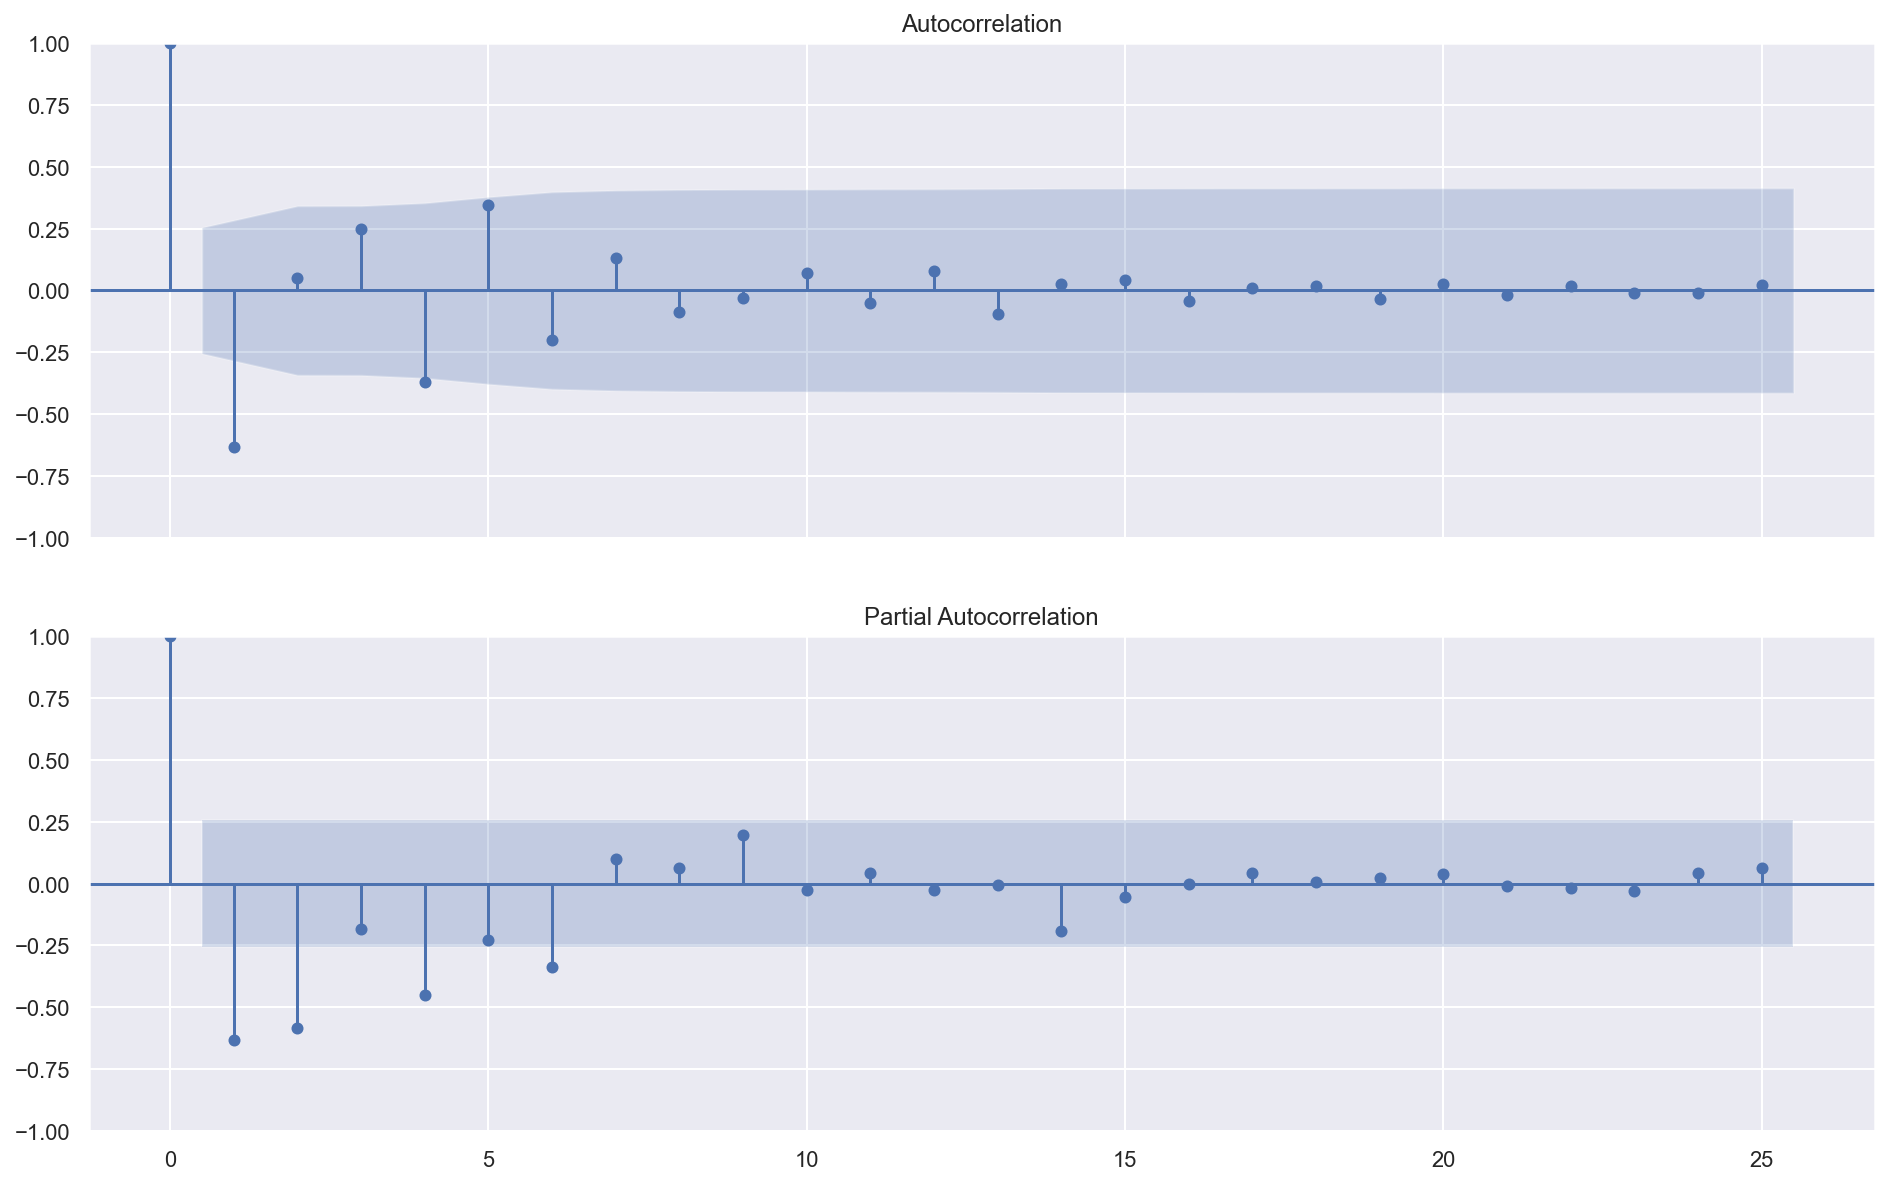

In [120]:
lags = 25
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

plot_acf(gdp_diff, lags=lags, ax=ax[0])
plot_pacf(gdp_diff, lags=lags, ax=ax[1])
plt.show();

По графику автокорреляции выбриаю значение q = 1

По графику частичной автокорреляции выбираю значение p = 2

In [121]:
q = 1
p = 2

In [122]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['GDP'], order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Thu, 27 Jul 2023   AIC                           2659.231
Time:                        16:20:36   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

На графике частичной автокорреляции есть еще одно значение дальше, последне значимое p = 6

In [123]:
p = 6
arima_model = ARIMA(train_df['GDP'], order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1306.570
Date:                Thu, 27 Jul 2023   AIC                           2629.140
Time:                        16:20:36   BIC                           2645.343
Sample:                    01-01-1960   HQIC                          2635.422
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3723      0.072    -19.184      0.000      -1.513      -1.232
ar.L2         -1.7074      0.156    -10.942      0.000      -2.013      -1.402
ar.L3         -1.5726      0.205     -7.658      0.000      -1.975      -1.170
ar.L4         -1.6483      0.141    -11.714      0.000      -1.924      -1.373
ar.L5         -1.2768      0.159     -8.021      0.000      -1.589      -0.965
ar.L6         -0.8853      0.148     -5.974      0.000      -1.176      -0.595
ma.L1         -0.5920      0.104     -5.673      0.000      -0.796      -0.387
sigma2      8.567e+18   3.66e-20   2.34e+38      0.000    8.57e+18    8.57e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                73.04
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              76.70   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.62e+54. Standard errors may be unstable.
"""

AIC для модели с p=6 ниже, выбираю ее

In [124]:
arima_pred = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
arima_pred

2019-01-01   69025971178.67
2020-01-01   77302051563.51
2021-01-01   64770758740.84
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [125]:
pred_df = pd.DataFrame(index=df.index)

pred_df['model_preds'] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
pred_df['GDP'] = df['GDP']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, 'model_preds_lower'] = forecast_df['lower GDP']
pred_df.at[test_df.index, 'model_preds_upper'] = forecast_df['upper GDP']

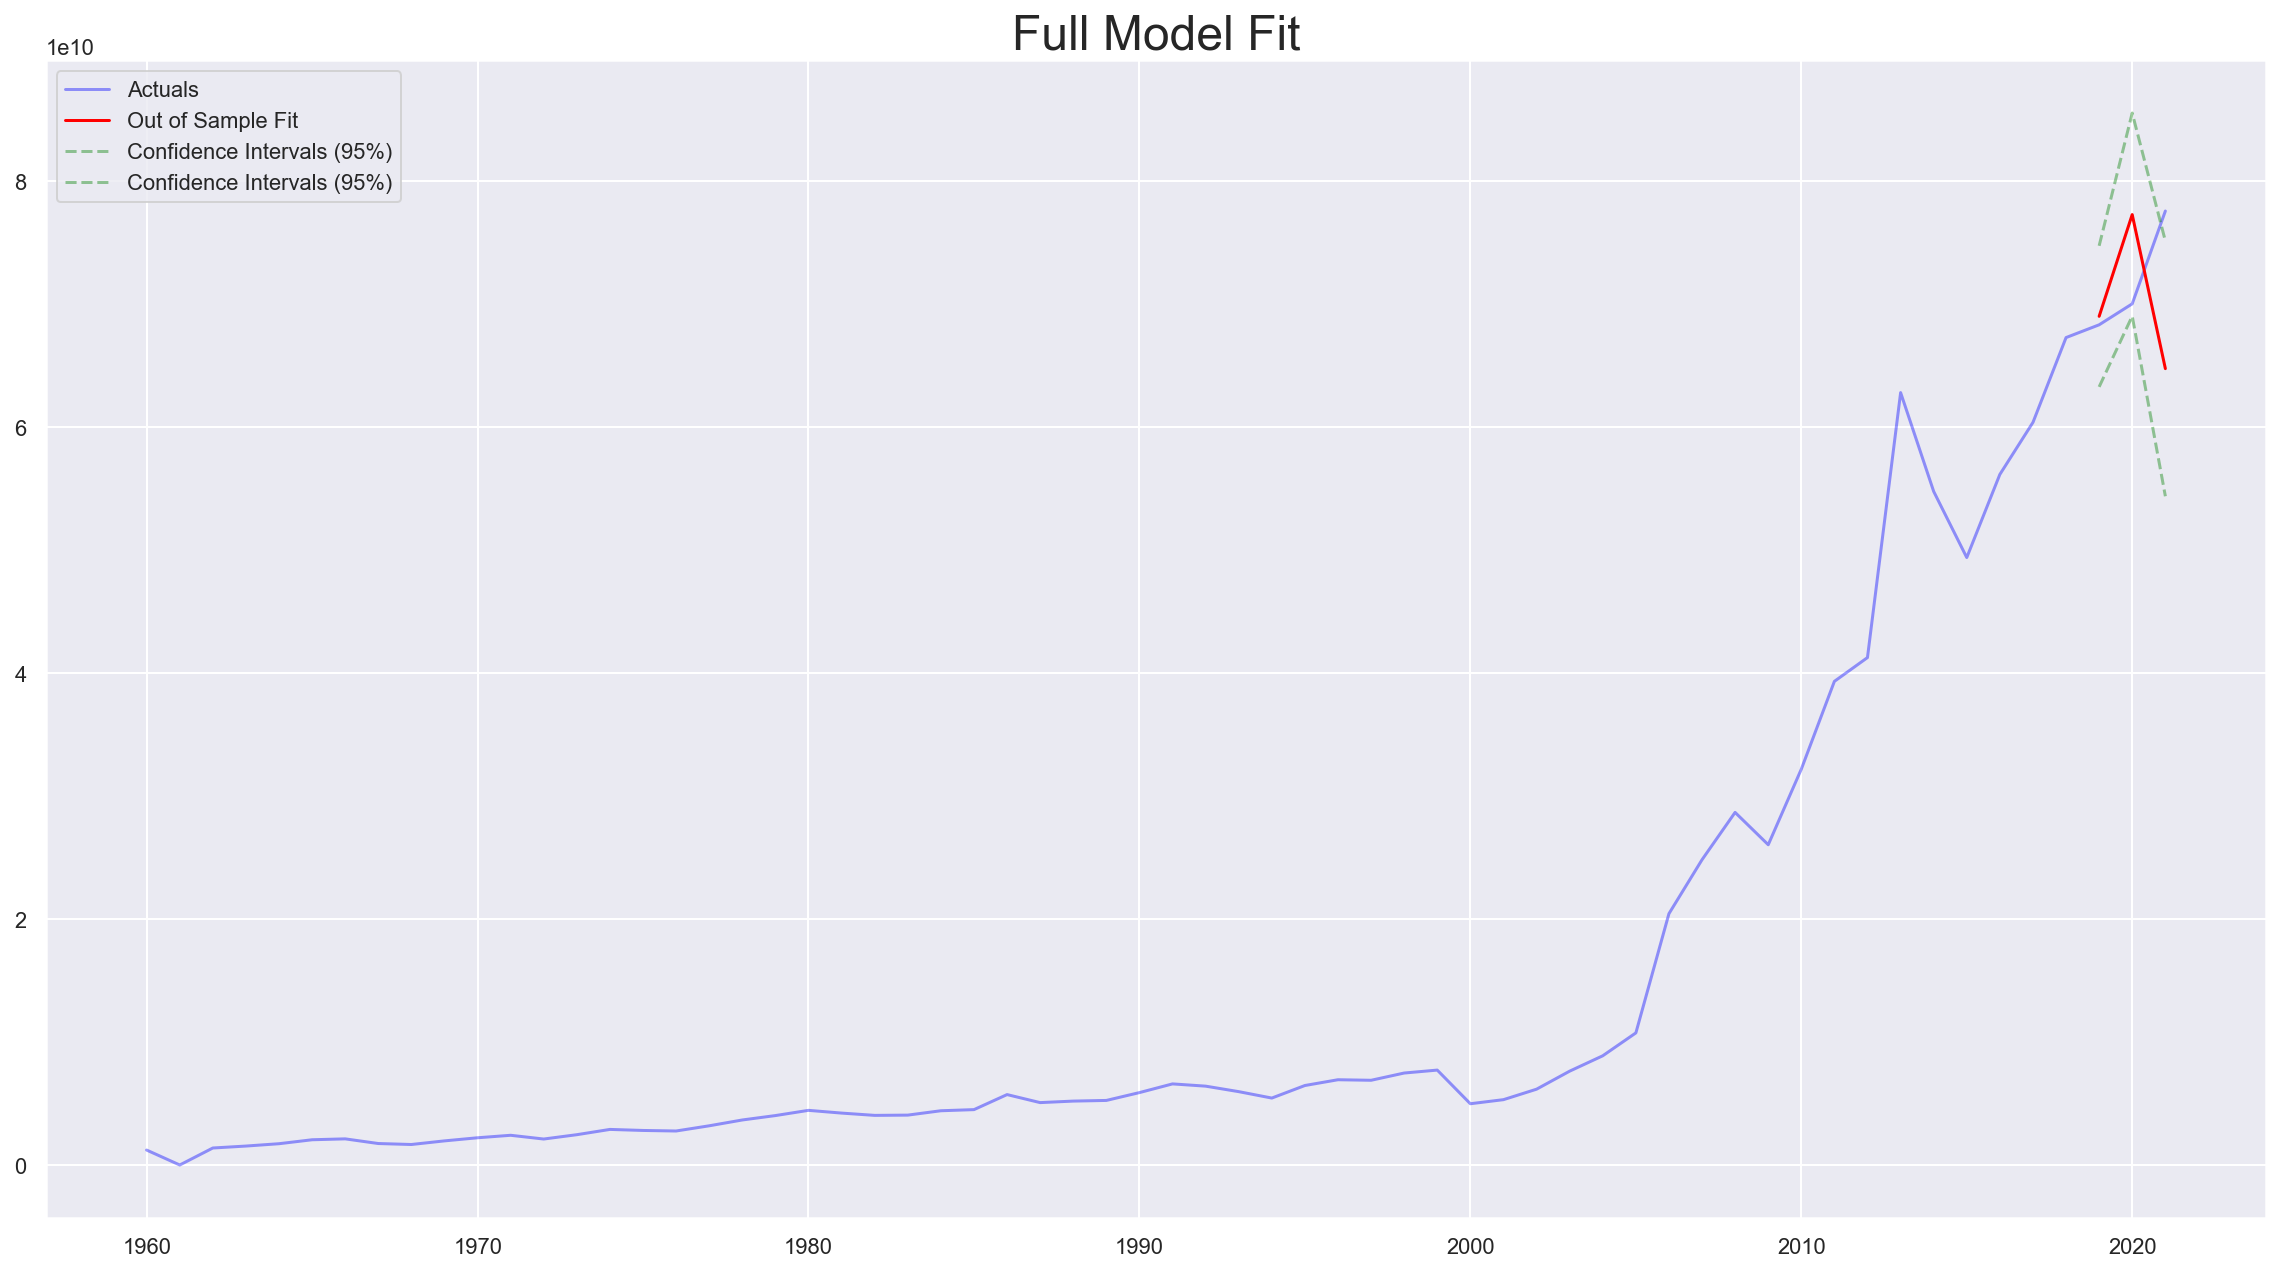

In [126]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(pred_df['GDP'], color='blue', label='Actuals', alpha=0.4)

ax.plot(
    pred_df.loc[test_df.index]['model_preds'],
    color='red',
    label='Out of Sample Fit',
)

ax.plot(
    pred_df.loc[test_df.index][['model_preds_lower', 'model_preds_upper']],
    color='green',
    linestyle='--',
    label='Confidence Intervals (95%)',
    alpha=0.4,
)

plt.title('Full Model Fit', size=24)
plt.tight_layout()
plt.legend()
plt.show()

In [127]:
# !pip install pmdarima

In [128]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    d=3,
    max_p=8,
    max_q=8,
    test='adf',
    error_action='ignore',
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.03 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.04 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.05 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.03 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.660 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Thu, 27 Jul 2023   AIC                           2659.231
Time:                        16:20:38   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

Незнаю почему, но автоперебор параметров не нашел результат, что я нашел вручную

# Обработка пропусков

In [129]:
df[df['GDP'] == 0]

,GDP
year,
1961-01-01,0.00


В данных есть пропуск в виде нулевого значения. 

Понятно что ВВП не мог быть нулевым. 

Логично для такого типа данных заполнить этот пропуск средним значением по годам до и после пропусков.

In [130]:
df['GDP'] = df['GDP'].replace(0, np.nan)
df['GDP'] = df['GDP'].interpolate(method='linear')

# Разделение выборки

In [132]:
test_period = 3 # последние три года оставляю для теста
train_df, test_df = df.iloc[:-test_period].copy(), df.iloc[-test_period:].copy()

### Проверка на стационарность

In [135]:
adf(df['GDP'])

Test-Statistic: 2.380848757555631
P-Value: 0.99900101016983
Time series is non-stationary


Ряд не стационарен, дифференцирую

In [136]:
gdp_diff = df['GDP'].diff().dropna()
adf(gdp_diff)

Test-Statistic: -1.7397184892921593
P-Value: 0.41077316906677114
Time series is non-stationary


Дифференцирую второй раз

In [137]:
gdp_diff = gdp_diff.diff().dropna()
adf(gdp_diff)

Test-Statistic: -1.7042548913504119
P-Value: 0.4289215730117663
Time series is non-stationary


Дифференцирую третий раз, ряд по прежнему нестационарен

In [138]:
gdp_diff = gdp_diff.diff().dropna()
adf(gdp_diff)

Test-Statistic: -5.456208629828435
P-Value: 2.578324497204482e-06
Time series is stationary!


Ряд так же стал стационарным только по третьего дифференцирования, значение d = 3

### Изучаю коррелограммы

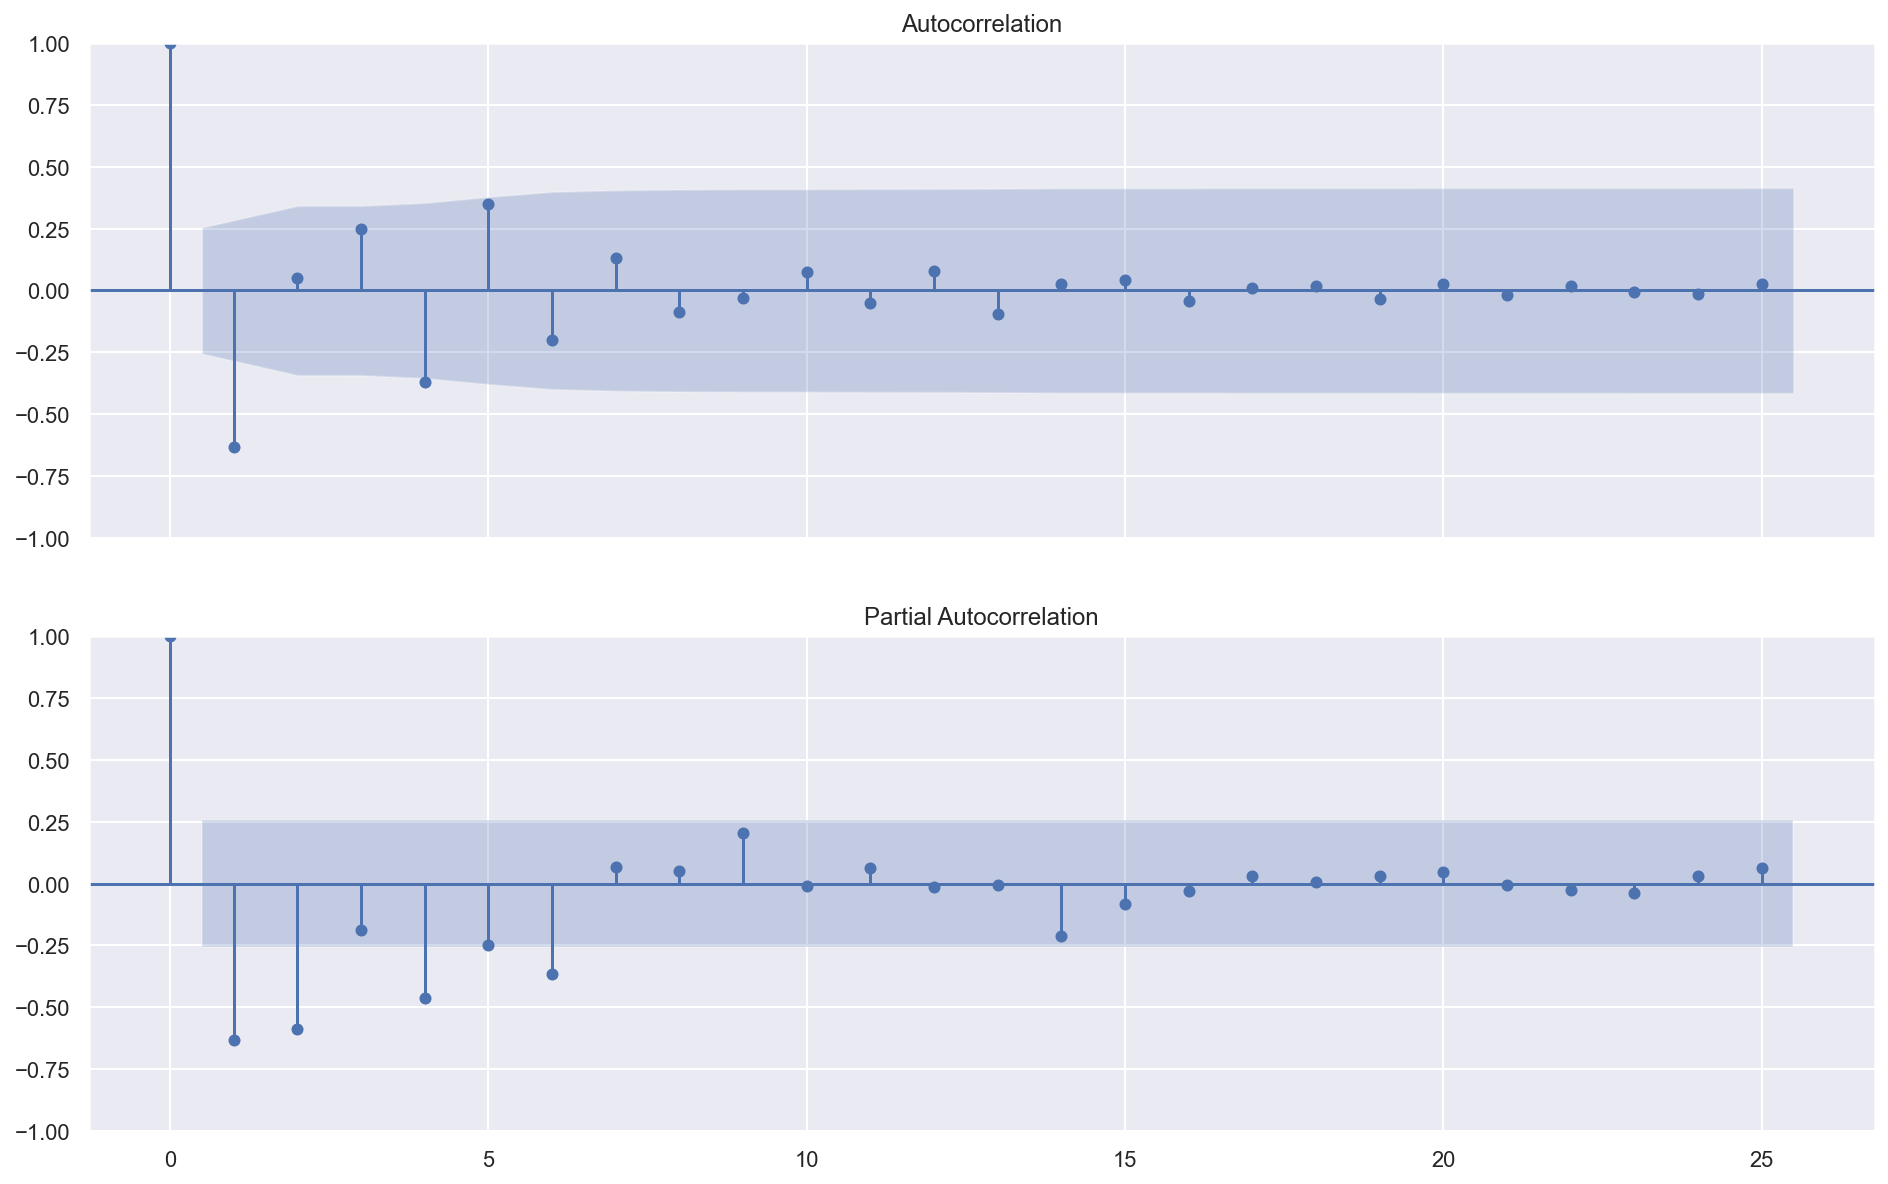

In [140]:
lags = 25
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

plot_acf(gdp_diff, lags=lags, ax=ax[0])
plot_pacf(gdp_diff, lags=lags, ax=ax[1])
plt.show();

По графику автокорреляции выбриаю значение q = 1

По графику частичной автокорреляции выбираю значение p = 6

In [141]:
q = 1
p = 6

In [142]:
arima_model = ARIMA(train_df['GDP'], order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1306.477
Date:                Thu, 27 Jul 2023   AIC                           2628.955
Time:                        16:27:20   BIC                           2645.157
Sample:                    01-01-1960   HQIC                          2635.236
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3720      0.070    -19.722      0.000      -1.508      -1.236
ar.L2         -1.7152      0.151    -11.394      0.000      -2.010      -1.420
ar.L3         -1.5816      0.197     -8.016      0.000      -1.968      -1.195
ar.L4         -1.6557      0.137    -12.060      0.000      -1.925      -1.387
ar.L5         -1.2760      0.157     -8.124      0.000      -1.584      -0.968
ar.L6         -0.8916      0.141     -6.340      0.000      -1.167      -0.616
ma.L1         -0.5844      0.105     -5.583      0.000      -0.789      -0.379
sigma2      8.426e+18   3.34e-20   2.52e+38      0.000    8.43e+18    8.43e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                76.24
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):             120.88   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+54. Standard errors may be unstable.
"""

AIC стала чуть лучше (меньше) 2628.955, а было 2629.140

In [143]:
arima_pred = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
arima_pred

2019-01-01   68650942327.32
2020-01-01   77046555845.49
2021-01-01   64510510916.70
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [144]:
pred_df = pd.DataFrame(index=df.index)

pred_df['model_preds'] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
pred_df['GDP'] = df['GDP']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, 'model_preds_lower'] = forecast_df['lower GDP']
pred_df.at[test_df.index, 'model_preds_upper'] = forecast_df['upper GDP']

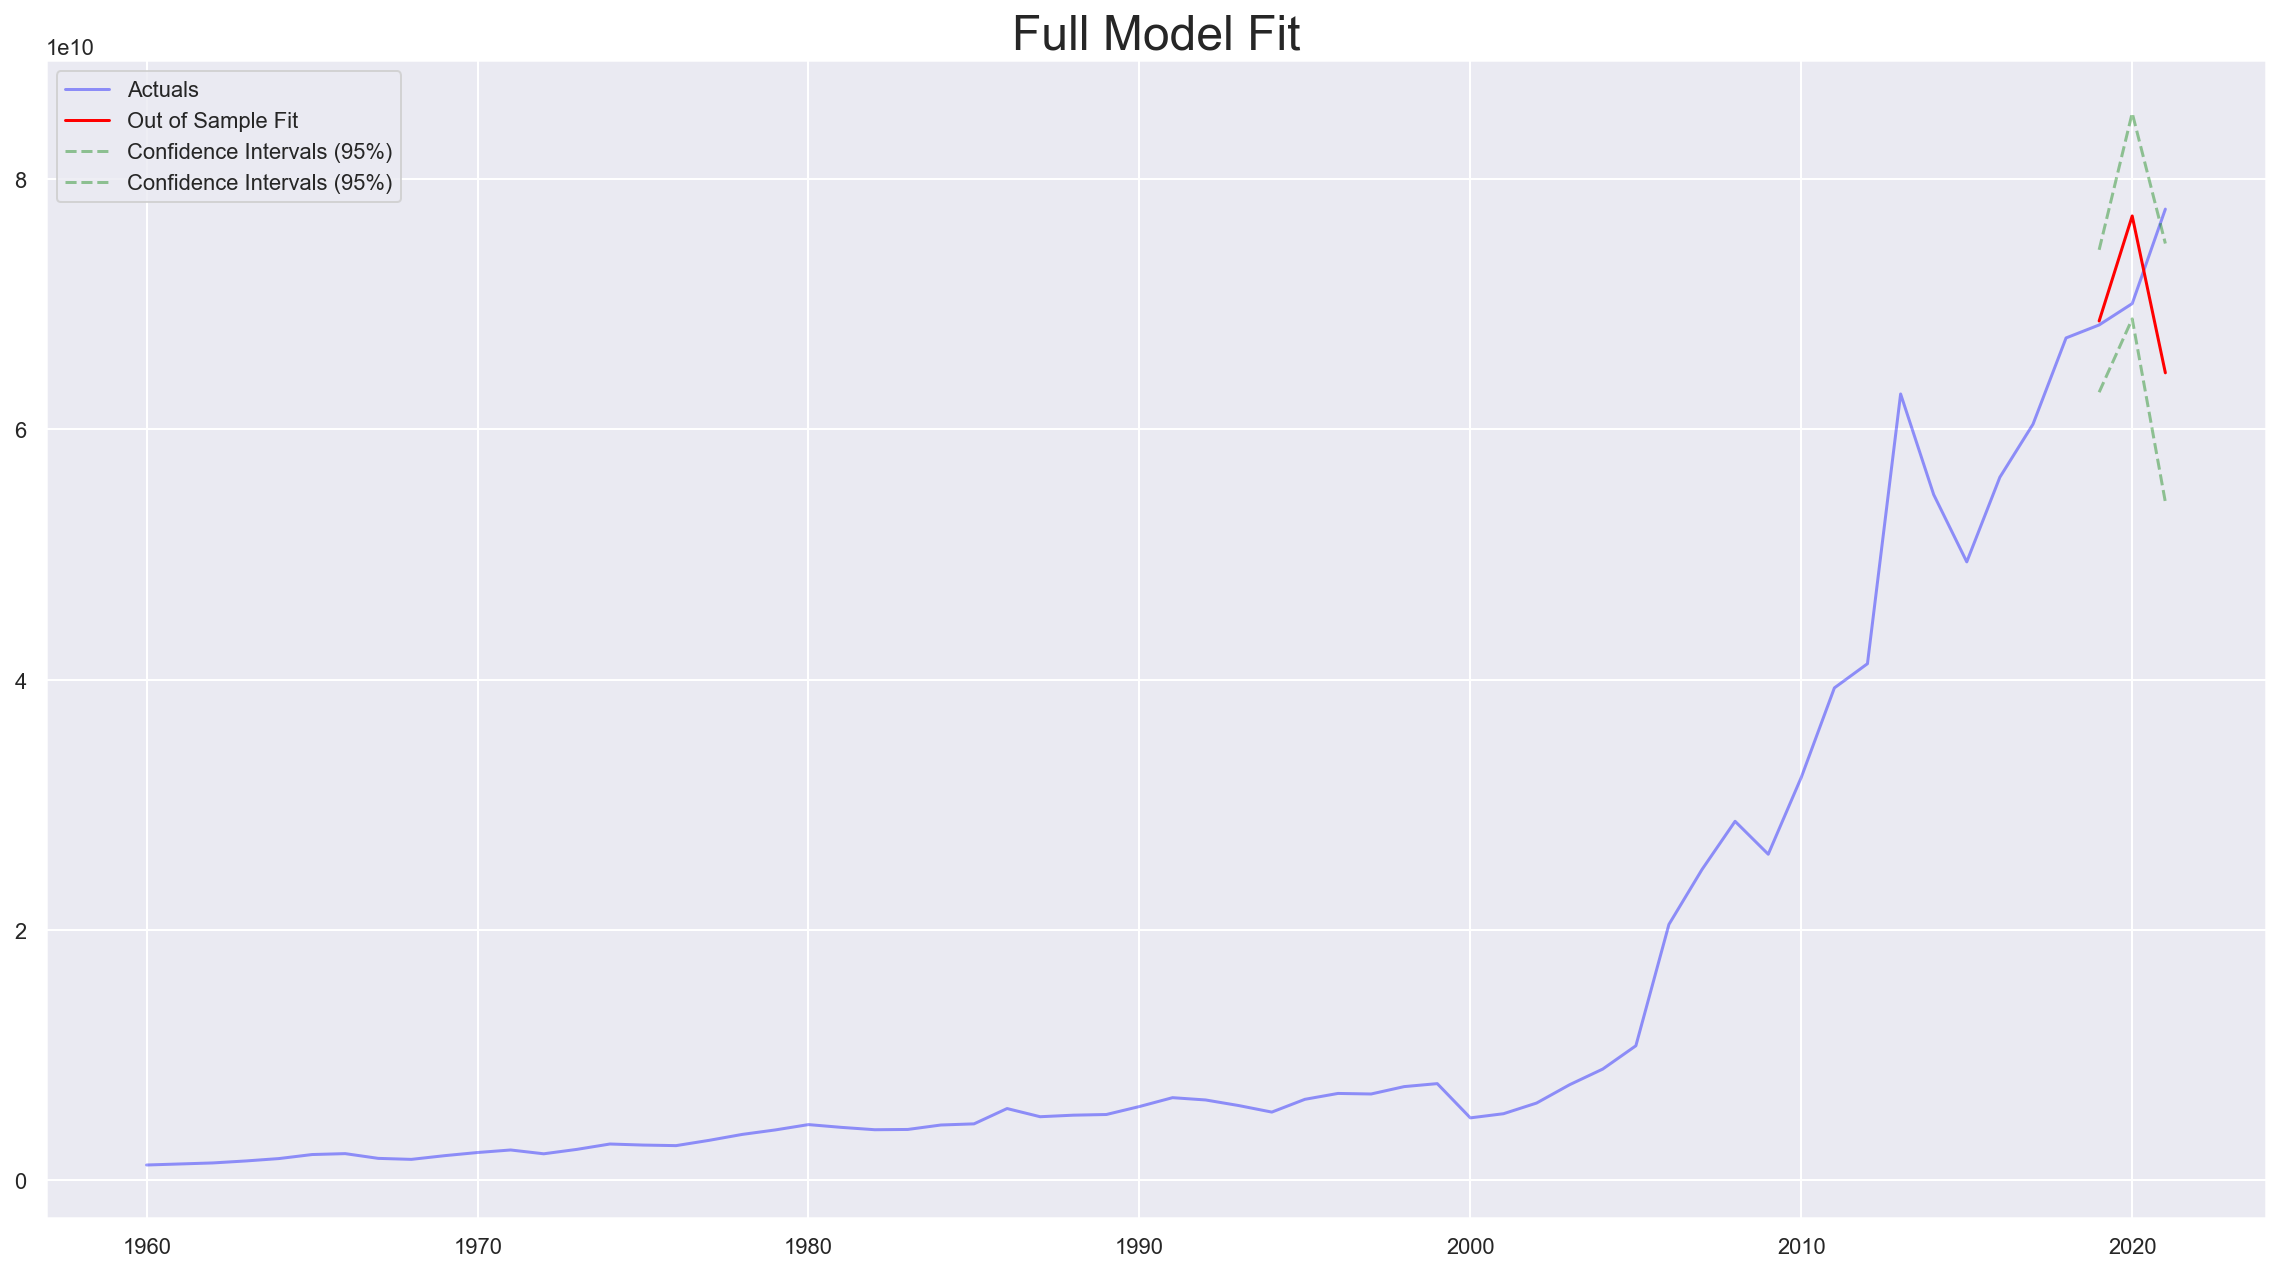

In [145]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(pred_df['GDP'], color='blue', label='Actuals', alpha=0.4)

ax.plot(
    pred_df.loc[test_df.index]['model_preds'],
    color='red',
    label='Out of Sample Fit',
)

ax.plot(
    pred_df.loc[test_df.index][['model_preds_lower', 'model_preds_upper']],
    color='green',
    linestyle='--',
    label='Confidence Intervals (95%)',
    alpha=0.4,
)

plt.title('Full Model Fit', size=24)
plt.tight_layout()
plt.legend()
plt.show()

Изменения незначительны, улучшения не видны невооруженным глазом.